In [20]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import data_processing
import math
import ipympl
from scipy import stats


In [2]:
%matplotlib widget

In [3]:
# Load raw data
data = np.loadtxt("raw_data/raw_data_20220802-164047")
data_crossed = np.loadtxt("raw_data/timestamp_crossed_data_20220802-164047")
data_timestamps = np.loadtxt("raw_data/timestamp_data_20220802-164047")
gui_data = np.load("../clock_gui/combo_info_20220802-164007.npz")


In [4]:
# Get gui combos 
repitions = gui_data['reps']
print("repitions:", gui_data['reps'])
print('Wt/Dt combos:', gui_data['combos'])

ID = np.log2(gui_data['combos'][:,1]/gui_data['combos'][:,0])
print("ID:",ID)

repitions: 5
Wt/Dt combos: [[ 100 2200]
 [ 170 1700]
 [ 250 1700]
 [ 250 1200]
 [ 170 2200]
 [ 100 1700]
 [ 250 2200]
 [ 170 1200]
 [ 100 1200]]
ID: [4.45943162 3.32192809 2.76553475 2.26303441 3.69389687 4.08746284
 3.13750352 2.81942775 3.5849625 ]


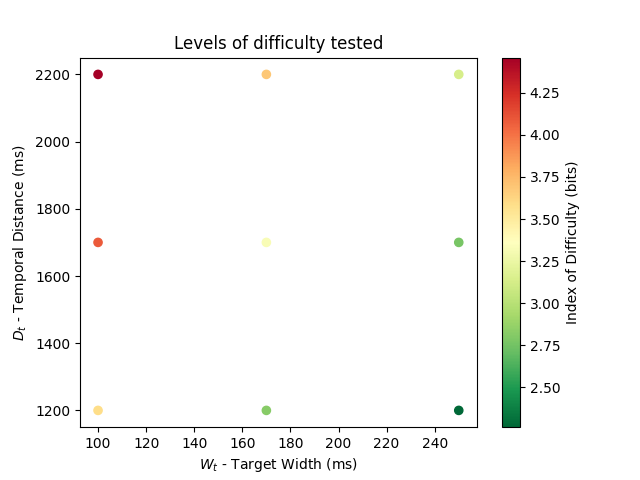

In [5]:
# Plot difficulty range
plt.figure()
plt.scatter(gui_data['combos'][:,0], gui_data['combos'][:,1], c=ID, s=35)
plt.title('Levels of difficulty tested')
plt.xlabel('$W_{t}$ - Target Width (ms)')
plt.ylabel('$D_{t}$ - Temporal Distance (ms)')
plt.set_cmap('RdYlGn_r')
cbar = plt.colorbar()
cbar.set_label('Index of Difficulty (bits)')
plt.show()

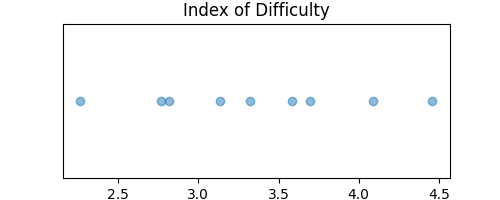

In [6]:
fig,ax = plt.subplots(1, figsize=(5, 2))
plt.scatter(ID, np.zeros(np.size(ID)), alpha=0.5)
# Turn off tick labels
ax.set_yticklabels([])
ax.set_yticks([])
plt.title("Index of Difficulty")
plt.xlabel("Index of Difficulty")
plt.show()


In [7]:
data_new = data[~(data == 0).all(axis=1)]
x_data = (data_new[:, 6] - data_new[0, 6])/4000

In [8]:
NUM_SAMPLES_BUFFER = 400
FILTER_AFTER_N = 100
BP_LOW_CUTOFF = 20
BP_HIGH_CUTOFF = 500
ORDER = 2
LP_HIGH_CUTOFF = 5

Mvc = 232 
percent_mvc = 0.3
mvc_threshold = percent_mvc*Mvc

process = data_processing.postProcessData(4000, data_new[:,0])
process.processAll(BP_LOW_CUTOFF, BP_HIGH_CUTOFF, LP_HIGH_CUTOFF, ORDER, FILTER_AFTER_N)


In [9]:

def findThresholdCrossing(lpData, threshold):
    threshold_crossings = np.diff(lpData > threshold, prepend=False)
    positive_difference = np.diff(lpData, prepend=0) >= 0 
    threshold_crossings_positive = np.argwhere(np.logical_and(threshold_crossings, positive_difference))[:,0]
    return threshold_crossings_positive

threshold_crossings_up = findThresholdCrossing(process.lpFilteredData, mvc_threshold)

def thresholdCrossed(lpData, threshold):
    threshold_crossings = np.diff(lpData > threshold)
    print("function crossing", threshold_crossings)
    positive_difference = np.diff(lpData) > 0    
    print("funciton difference", positive_difference) 
    thresholdCrossed =  np.any(np.logical_and(threshold_crossings, positive_difference))
    return thresholdCrossed

In [10]:
stop_cue = (np.where(np.diff(data_new[:, 4]) == 1)[0])
start_cue = (np.where(np.diff(data_new[:, 4]) == -1)[0])

if stop_cue[0] < start_cue[0]:
    stop_cue = stop_cue[1:]

print("threshold corssing:", threshold_crossings_up)
print("start:", start_cue)
print("stop:", stop_cue)

threshold corssing: [ 18925  27891  36683  45512  53514  65790  72262  79248  86205  92676
 107401 115843 121983 128269 135538 150664 155016 159745 164879 167027
 170081 179903 187967 197181 205816 214882 223444 230681 237848 243729
 251310 287949 290825 293306 294881 312035 313361 363619 364958 583842
 586970 597416 607660 608665 612713 613653]
start: [  7595  19015  27825  36640  45416  54273  65617  72450  79197  86082
  92787 108413 115197 122032 128810 135591 150581 155399 160282 165018
 169895 179893 188574 197421 206228 214974 224023 230770 237573 244474
 251169 287861 296749 305637 314525 322605 331493 340381 351693 360581
 368661 373509 378357 383205 388053 392901 397749 402597 407446 412294
 417141 421990 426838 440574 522182 527030 531878 536726 541574 546422
 551270 556118 603790 608638 613486]
stop: [  9714  19488  28255  37060  45796  54620  66286  73070  79928  86666
  93540 109421 116202 123044 129794 136600 151603 156464 161250 166026
 170780 180455 189269 198054 20686

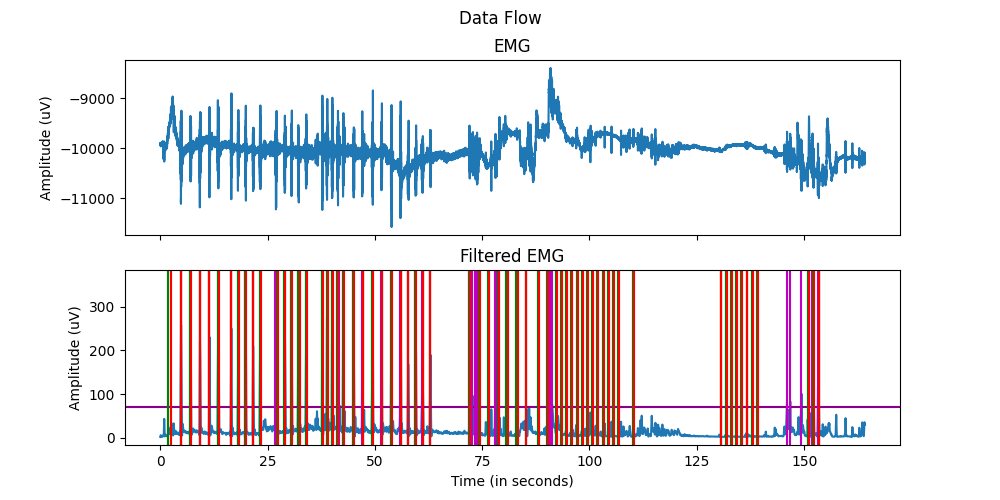

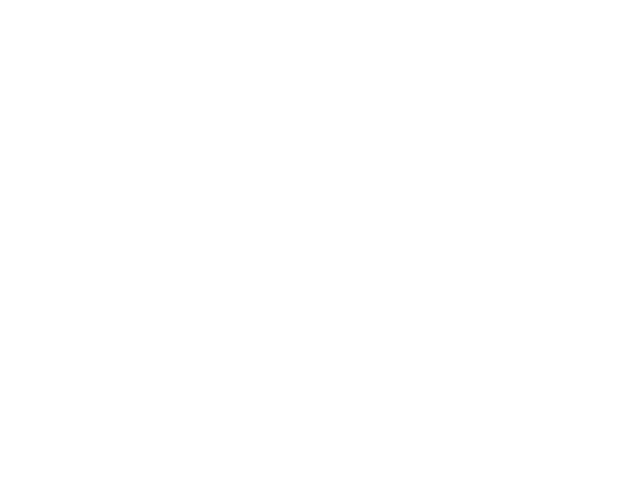

In [11]:
plt.figure()
fig, axs = plt.subplots(2, figsize=(10, 5), sharex=True) # dont need status or lsl clock
fig.suptitle('Data Flow')

axs[0].plot(x_data, data_new[:, 0])
axs[0].title.set_text('EMG')

for xc in start_cue:
    axs[1].axvline(x=xc/4000, color='g')
for xc in stop_cue:
    axs[1].axvline(x=xc/4000, color='r')

axs[1].plot(x_data, process.lpFilteredData)
axs[1].title.set_text('Filtered EMG')
axs[1].axhline(y=mvc_threshold, color='darkmagenta')

for ups in threshold_crossings_up:
    axs[1].axvline(x=ups/4000, color='m')

for xc in start_cue:
    axs[1].axvline(x=xc/4000, color='g')
for xc in stop_cue:
    axs[1].axvline(x=xc/4000, color='r')

    
axs[1].set_xlabel('Time (in seconds)')
axs[1].set_ylabel('Amplitude (uV)')
axs[0].set_ylabel('Amplitude (uV)')
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.show()



In [12]:
# Exclude the first pulse - that is ardunio power cycling
start_cue = start_cue[1:] # [1:]
stop_cue = stop_cue[1:] #[1:]

threshold_closest = np.empty(np.size(start_cue[:]))
threshold_closest[:] = np.nan
correct = np.empty(np.size(start_cue[:]))
###for every value in the strt_cue 
for idx_cue, cue in enumerate(start_cue[:]):

    after_start = start_cue[idx_cue] <= threshold_crossings_up
    before_stop = threshold_crossings_up <= stop_cue[idx_cue]
    # check if there is a value between start_cue and stop cue
    if np.any(np.logical_and(after_start, before_stop)):
        in_target = np.argwhere(np.logical_and(after_start, before_stop))
        closet_value = in_target[0]
        threshold_closest[idx_cue] = threshold_crossings_up[in_target[0]]
        correct[idx_cue] = True
    else:
        # if not - get closet 
        idx = (np.abs(threshold_crossings_up - start_cue[idx_cue])).argmin()

        threshold_closest[idx_cue] = threshold_crossings_up[idx]
        correct[idx_cue] = False
         # get rid of values greater than half the distance between the next cue 



In [13]:
from numpy import NaN


print("closest:", threshold_closest)
print("correctness:", correct)

threshold_distance = threshold_closest - start_cue
print("distance away:", threshold_distance)


threshold_distance[threshold_distance > 4000] = NaN
threshold_distance[threshold_distance < -4000] = NaN
print("distance away:", threshold_distance)


closest: [ 18925.  27891.  36683.  45512.  53514.  65790.  72262.  79248.  86205.
  92676. 107401. 115843. 121983. 128269. 135538. 150664. 155016. 159745.
 164879. 170081. 179903. 187967. 197181. 205816. 214882. 223444. 230681.
 237848. 243729. 251310. 287949. 294881. 312035. 313361. 313361. 313361.
 363619. 363619. 363619. 364958. 364958. 364958. 364958. 364958. 364958.
 364958. 364958. 364958. 364958. 364958. 364958. 364958. 364958. 583842.
 583842. 583842. 583842. 583842. 583842. 583842. 583842. 607660. 608665.
 613653.]
correctness: [0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
distance away: [-9.0000e+01  6.6000e+01  4.3000e+01  9.6000e+01 -7.5900e+02  1.7300e+02
 -1.8800e+02  5.1000e+01  1.2300e+02 -1.1100e+02 -1.0120e+03  6.4600e+02
 -4.9000e+01 -5.4100e+02 -5.3000e+01  8.3000e+01 -3.8300e+02 -5.3700e+02
 -1.3900e+02  1.8600e+02  1

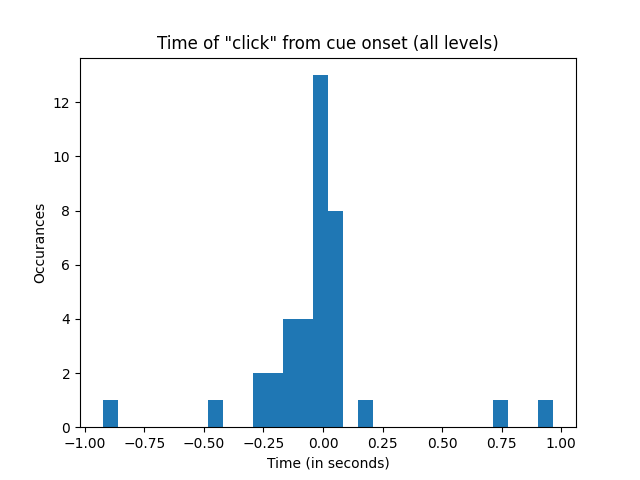

In [14]:
plt.figure()
plt.hist(threshold_distance/4000, bins=30)
plt.title('Time of "click" from cue onset (all levels)')
plt.xlabel('Time (in seconds)')
plt.ylabel('Occurances')
plt.show()

In [25]:
rt = threshold_distance/4000
print(rt)
rt = rt[~np.isnan(rt)]
print(rt)

[-0.0225   0.0165   0.01075  0.024   -0.18975  0.04325 -0.047    0.01275
  0.03075 -0.02775 -0.253    0.1615  -0.01225 -0.13525 -0.01325  0.02075
 -0.09575 -0.13425 -0.03475  0.0465   0.0025  -0.15175 -0.06    -0.103
 -0.023   -0.14475 -0.02225  0.06875 -0.18625  0.03525  0.022   -0.467
      nan -0.291        nan      nan      nan      nan  0.7595  -0.92575
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan  0.9675   0.00675  0.04175]
[-0.0225   0.0165   0.01075  0.024   -0.18975  0.04325 -0.047    0.01275
  0.03075 -0.02775 -0.253    0.1615  -0.01225 -0.13525 -0.01325  0.02075
 -0.09575 -0.13425 -0.03475  0.0465   0.0025  -0.15175 -0.06    -0.103
 -0.023   -0.14475 -0.02225  0.06875 -0.18625  0.03525  0.022   -0.467
 -0.291    0.7595  -0.92575  0.9675   0.00675  0.04175]


In [33]:
rt_normalized = (rt - np.mean(rt))/np.std(rt)
stats.kstest(rt_normalized, stats.norm.cdf)

KstestResult(statistic=0.2887342551109311, pvalue=0.002675022232320967)

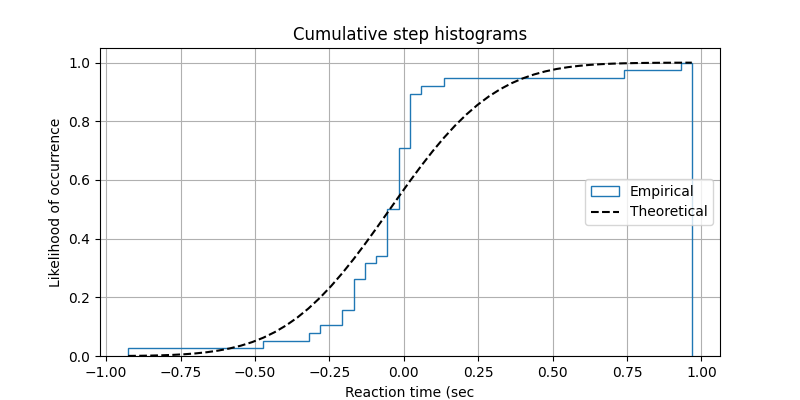

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab

np.random.seed(0)

mu = np.mean(rt)
sigma = np.std(rt)
n_bins = 50

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(rt, n_bins, density=1, histtype='step',
                           cumulative=True, label='Empirical')

# Add a line showing the expected distribution.
y = stats.norm.pdf(bins, mu, sigma).cumsum()
y /= y[-1]

ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')



# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('Reaction time (sec)')
ax.set_ylabel('Likelihood of occurrence')

plt.show()

In [15]:
repitions = gui_data['reps'] 
print("repitions:", repitions)
level = np.arange(len(correct))//repitions
print('Levels:', level)
performance = np.bincount(level,correct)/np.bincount(level)
print('performance per level:', performance)


repitions: 5
Levels: [ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11 12 12 12 12]
performance per level: [0.6 0.6 0.2 0.4 0.2 0.4 0.2 0.  0.  0.  0.  0.  0.5]


In [16]:
from matplotlib.pyplot import box

box_plot_data = np.split(threshold_distance/4000, np.unique(level, return_index=True)[1][1:])
print(box_plot_data)

[array([-0.0225 ,  0.0165 ,  0.01075,  0.024  , -0.18975]), array([ 0.04325, -0.047  ,  0.01275,  0.03075, -0.02775]), array([-0.253  ,  0.1615 , -0.01225, -0.13525, -0.01325]), array([ 0.02075, -0.09575, -0.13425, -0.03475,  0.0465 ]), array([ 0.0025 , -0.15175, -0.06   , -0.103  , -0.023  ]), array([-0.14475, -0.02225,  0.06875, -0.18625,  0.03525]), array([ 0.022, -0.467,    nan, -0.291,    nan]), array([     nan,      nan,      nan,  0.7595 , -0.92575]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]), array([    nan, 0.9675 , 0.00675, 0.04175])]


In [17]:
for idx, data in enumerate(box_plot_data):
    box_plot_data[idx] = data[~np.isnan(data)]



In [18]:
np.shape(ID)[0]

9

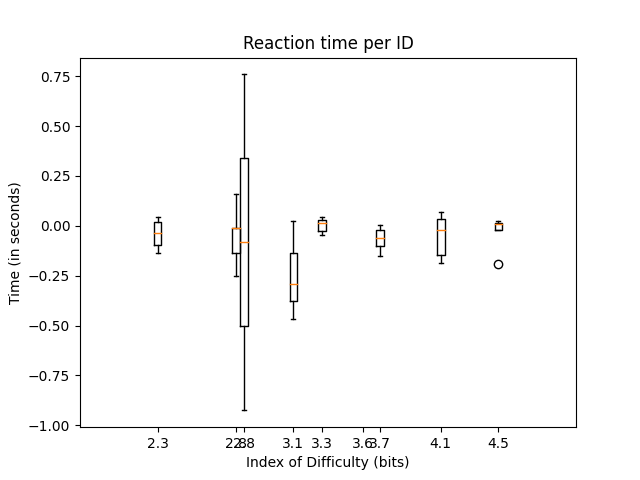

In [40]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(box_plot_data[0:np.shape(ID)[0]], positions=ID.round(3), widths=0.05)
plt.title('Reaction time per ID')
plt.ylabel('Time (in seconds)')
plt.xlabel('Index of Difficulty (bits)')
from matplotlib.ticker import FormatStrFormatter
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

In [35]:
print(performance)

[0.6 0.6 0.2 0.4 0.2 0.4 0.2 0.  0.  0.  0.  0.  0.5]


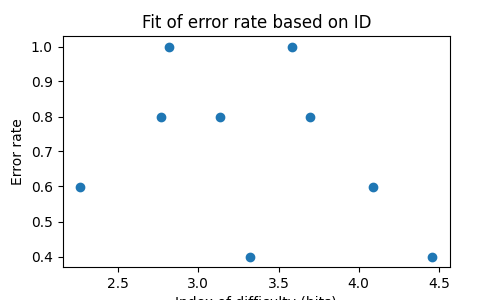

In [55]:
plt.figure(figsize=(5,3))
plt.scatter(ID, 1-performance[0:np.shape(ID)[0]])
plt.title('Fit of error rate based on ID')
plt.xlabel('Index of difficulty (bits)')
plt.ylabel('Error rate')
plt.show()
# plt.xlim([0, 4])
plt.ylim([0, 1.05])
plt.tight_layout()

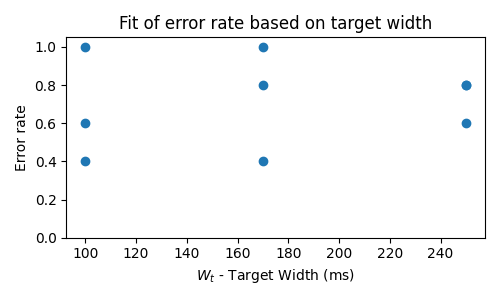

In [52]:
plt.figure(figsize=(5,3))
plt.scatter(gui_data['combos'][:,0], 1-performance[0:np.shape(ID)[0]])
plt.title('Fit of error rate based on target width')
plt.xlabel('$W_{t}$ - Target Width (ms)')
plt.ylabel('Error rate')
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()


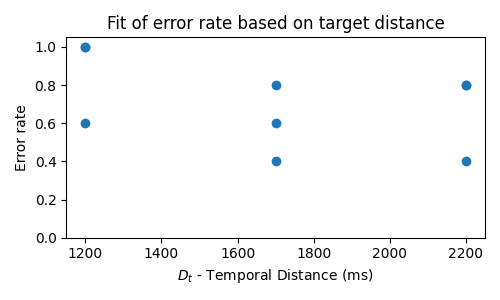

In [54]:
plt.figure(figsize=(5,3))
plt.scatter(gui_data['combos'][:,1], 1-performance[0:np.shape(ID)[0]])
plt.title('Fit of error rate based on target distance')
plt.xlabel('$D_{t}$ - Temporal Distance (ms)')
plt.ylabel('Error rate')
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()